In [25]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time


In [22]:
import requests
import json

class MicroscopeConsole(object):
    def __init__(self, host, port=5000):
        self.host = host
        self.port = port
        
    @property
    def base_uri(self):
        return "http://{}:{}/api/v1".format(self.host, self.port)
        
    def run_short(self, code):
        """Run a short (blocking) task on the microscope.
        
        The code supplied can put things in ``response`` which is a
        dictionary.  This is available in the ``return`` key of the 
        dictionary that's returned.
        """
        r = requests.post(self.base_uri+"/plugin/console/short_task", 
                          json={"code":code})
        r.raise_for_status()
        return r.json()
        
    def start_background_task(self, code):
        """Start a long (non-blocking) task on the microscope.
        
        The returned dictionary represents the task.
        """
        r = requests.post(self.base_uri+"/plugin/console/background_task", 
                          json={"code":code})
        r.raise_for_status()
        return r.json()
        
    def query_background_task(self, task):
        """Request the status of a background task"""
        r = requests.get(self.base_uri+"/task/{}/".format(task['id']))
        r.raise_for_status()
        return r.json()
    
    def await_background_task(self, t):
        """Poll a task until it's done"""
        r = {"status":"running"}
        while r["status"] == "running":
            r = self.query_background_task(t)
            time.sleep(0.2)
        return r
    
    def run_background(self, code):
        """Start a long task on the microscope and block until it's finished.
        
        The return value is as for ``run_short``
        """
        t = self.start_background_task(code)
        return self.await_background_task(t)
    
    def fast_autofocus(self, dz, backlash=0):
        """Use the now-extant fast autofocus plugin!"""
        r = requests.post(self.base_uri+"/plugin/default/autofocus/fast_autofocus", 
                          json={"dz":dz, "backlash":backlash})
        r.raise_for_status()
        return self.await_background_task(r.json())


In [3]:
con = MicroscopeConsole("localhost",62201)
code = """
response['test'] = "I worked!"
"""
t = con.run_background(code)
t['return']

{u'test': u'I worked!'}

In [74]:
con = MicroscopeConsole("raspberrypi.local",5000)
#con = MicroscopeConsole("localhost",5000)

In [6]:
r = requests.post(con.base_uri+"/invalid")
r.raise_for_status()
r

HTTPError: 404 Client Error: NOT FOUND for url: http://localhost:62201/api/v1/invalid

In [62]:
code="""
import time
import io
import threading

cam = microscope.camera
stage = microscope.stage

jpegs = []
jtimes = []
event = threading.Event()

def measure_jpegs():
    global io, event, jpegs, jtimes, cam, time
    with io.BytesIO() as b:
        while not event.is_set():
            cam.camera.capture(b, format="jpeg", use_video_port=True)
            jtimes.append(time.time())
            jpegs.append(b.tell())
            b.seek(0)
t = threading.Thread(target=measure_jpegs)
t.start()
response['starttime'] = time.time()
stage.focus_rel(-1000)
stage.focus_rel(2000)
stage.focus_rel(-2000)
stage.focus_rel(2000)
stage.focus_rel(-1000)
response['endtime']= time.time()
event.set()
t.join()
response['jtimes']=jtimes
response['jpegs']=jpegs
"""
t = con.run_background(code)
r = t['return']


<IPython.core.display.Javascript object>


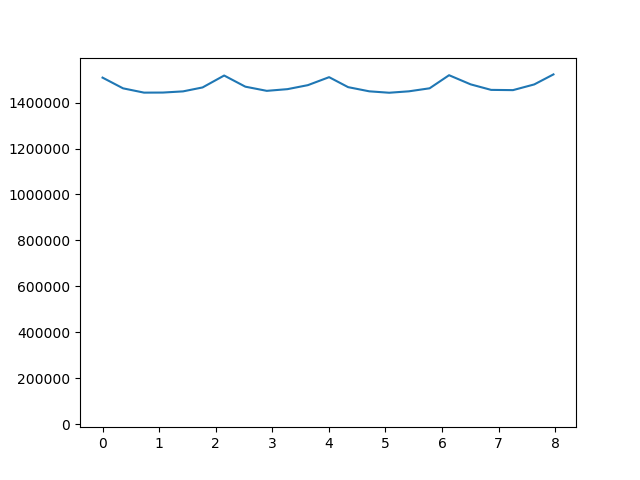

In [63]:
t = np.array(r['jtimes'])
t -= t[0]
size = np.array(r['jpegs'])
plt.plot(t, size)

In [7]:
code="""
import time
import io
import threading

cam = microscope.camera
stage = microscope.stage

jpegs = []
jtimes = []
event = threading.Event()

def measure_jpegs():
    global io, event, jpegs, jtimes, cam, time
    while not event.is_set():
        jtimes.append(time.time())
        jpegs.append(len(cam.get_frame()))
t = threading.Thread(target=measure_jpegs)
t.start()
response['starttime'] = time.time()
stage.focus_rel(-1000)
stage.focus_rel(2000)
stage.focus_rel(-1000)
response['endtime']= time.time()
event.set()
t.join()
response['jtimes']=jtimes
response['jpegs']=jpegs
"""
t = con.run_background(code)
r = t['return']

ConnectionError: ('Connection aborted.', error(10054, 'An existing connection was forcibly closed by the remote host'))

got 122 frames in 4.01669859886 seconds


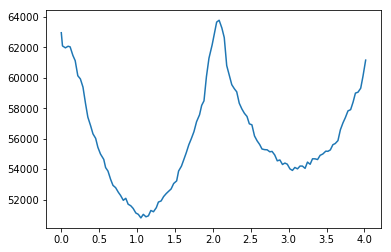

In [79]:
t = np.array(r['jtimes'])
t -= t[0]
size = np.array(r['jpegs'])
plt.plot(t, size)
print("got {} frames in {} seconds".format(len(t), np.max(t)))

In [79]:
r = con.fast_autofocus(3000, 256)

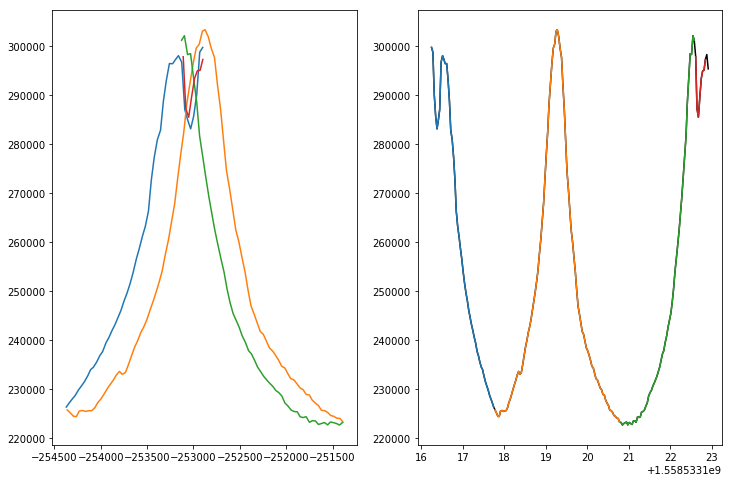

In [80]:
d = {k: np.array(v) for k, v in r['return'].items()}
d['jpeg_zs'] = np.interp(d['jpeg_times'], d['stage_times'], d['stage_positions'][:,2])
moves = []
start = 0
for t in d['stage_times'][1::2]:
    end = np.argmax(d['jpeg_times'] > t)
    if end > start:
        rr = slice(start, end)
        move = {'z': d['jpeg_zs'][rr], 
                't': d['jpeg_times'][rr],
                's': d['jpeg_sizes'][rr]}
        moves.append(move)
        start = end
f, ax = plt.subplots(1,2, figsize=(12,8))
ax[1].plot(d["jpeg_times"],d["jpeg_sizes"],color='black')
for m in moves:
    ax[0].plot(m['z'],m['s'])
    ax[1].plot(m["t"],m["s"])

In [65]:
d['jpeg_zs'][np.argmax(d['jpeg_sizes'])]

-266235.97836803441

In [71]:
np.mean(np.diff(d['jpeg_times']))

0.033329224586486815